#### https://mp.weixin.qq.com/s/_QMLM4jIpIoGbLBOxu3s-w

In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold,KFold
from matplotlib.pyplot import plot, show

In [2]:
LABEL = 'label'

df_train = pd.read_csv('./data/商品需求训练集.csv')
df_train_order = pd.read_csv('./data/商品月订单训练集.csv')
df_train['date'] = pd.to_datetime(df_train['date'])
df_train['year'] = df_train['date'].dt.year
df_train['month'] = df_train['date'].dt.month
df_train = df_train.groupby(['product_id', 'year', 'month'])[['is_sale_day', 'label']].sum().reset_index()
df_train = df_train.merge(df_train_order, on=['product_id', 'year', 'month'], how='left')

df_test = pd.read_csv('./data/商品需求测试集.csv')
df_test_order = pd.read_csv('./data/商品月订单测试集.csv')
df_test['date'] = pd.to_datetime(df_test['date'])
df_test['year'] = df_test['date'].dt.year
df_test['month'] = df_test['date'].dt.month
df_test = df_test.groupby(['product_id', 'year', 'month'])[['is_sale_day']].sum().reset_index()
df_test = df_test.merge(df_test_order, on=['product_id', 'year', 'month'], how='left')

df = pd.concat([df_train, df_test])

In [3]:
df

,product_id,year,month,is_sale_day,label,type,order,start_stock,end_stock
0,1001,2018,2,0,517.0,A1,1129.0,47.0,70.0
1,1001,2018,3,0,3190.0,A1,3568.0,70.0,91.0
2,1001,2018,4,0,4186.0,A1,4560.0,91.0,110.0
3,1001,2018,5,0,5412.0,A1,7521.0,110.0,47.0
4,1001,2018,6,0,5665.0,A1,7687.0,47.0,41.0
...,...,...,...,...,...,...,...,...,...
622,1209,2021,2,0,NaN,A1,1128.0,55.0,78.0
623,1209,2021,3,0,NaN,A1,10756.0,78.0,65.0
624,1210,2021,1,31,NaN,A3,15182.0,90.0,347.0
625,1210,2021,2,28,NaN,A3,1128.0,347.0,305.0


In [4]:
# feats = ['month', 'order', 'start_stock', 'end_stock']
for i in range(1, 8):
    for f in [LABEL, 'order', 'start_stock', 'end_stock']:
        df[f+'_shift_%d'%i] = df.groupby('product_id')[f].shift(i+3)

for i in range(4):
    for f in ['order', 'start_stock', 'end_stock']:
        df[f+'_shift_-%d'%i] = df.groupby('product_id')[f].shift(-i)

for i in [3, 6]:
    for f in [LABEL, 'order', 'start_stock', 'end_stock']:
        df[f+'_mean_%d'%i] = df[[f+'_shift_%d'%i for i in range(1, i+1)]].mean(axis=1)
        df[f+'_std_%d'%i] = df[[f+'_shift_%d'%i for i in range(1, i+1)]].std(axis=1)
        df[f+'_median_%d'%i] = df[[f+'_shift_%d'%i for i in range(1, i+1)]].median(axis=1)

In [5]:
df_train

,product_id,year,month,is_sale_day,label,type,order,start_stock,end_stock
0,1001,2018,2,0,517.0,A1,1129.0,47.0,70.0
1,1001,2018,3,0,3190.0,A1,3568.0,70.0,91.0
2,1001,2018,4,0,4186.0,A1,4560.0,91.0,110.0
3,1001,2018,5,0,5412.0,A1,7521.0,110.0,47.0
4,1001,2018,6,0,5665.0,A1,7687.0,47.0,41.0
...,...,...,...,...,...,...,...,...,...
7283,1210,2020,8,31,6443.0,A3,14180.0,97.0,94.0
7284,1210,2020,9,30,6432.0,A3,15034.0,94.0,79.0
7285,1210,2020,10,31,5803.0,A3,14312.0,79.0,61.0
7286,1210,2020,11,30,6138.0,A3,16180.0,81.0,88.0


In [6]:
le = LabelEncoder()
df['type'] = le.fit_transform(df['type'])
df['type'] = df['type'].astype('category')

df['product_id'] = df['product_id'].astype('category')

df_train = df[df[LABEL].notna()].reset_index(drop=True)
df_test = df[df[LABEL].isna()].reset_index(drop=True)

feats = [f for f in df_test if f not in ['year', 'label']]

df_train[LABEL+'_log1p'] = np.log1p(df_train[LABEL])
df_train

,product_id,year,month,is_sale_day,label,type,order,start_stock,end_stock,label_shift_1,...,order_mean_6,order_std_6,order_median_6,start_stock_mean_6,start_stock_std_6,start_stock_median_6,end_stock_mean_6,end_stock_std_6,end_stock_median_6,label_log1p
0,1001,2018,2,0,517.0,0,1129.0,47.0,70.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.249975
1,1001,2018,3,0,3190.0,0,3568.0,70.0,91.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.068090
2,1001,2018,4,0,4186.0,0,4560.0,91.0,110.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.339740
3,1001,2018,5,0,5412.0,0,7521.0,110.0,47.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.596559
4,1001,2018,6,0,5665.0,0,7687.0,47.0,41.0,517.0,...,1129.000000,NaN,1129.0,47.000000,NaN,47.0,70.000000,NaN,70.0,8.642239
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7283,1210,2020,8,31,6443.0,2,14180.0,97.0,94.0,3880.0,...,7368.166667,4952.213784,5788.5,250.500000,142.285277,228.0,259.333333,138.543375,228.0,8.770905
7284,1210,2020,9,30,6432.0,2,15034.0,94.0,79.0,4852.0,...,7334.000000,4908.777974,5788.5,257.166667,133.954345,228.0,245.333333,155.277386,224.5,8.769196
7285,1210,2020,10,31,5803.0,2,14312.0,79.0,61.0,4425.0,...,7152.166667,4617.261761,5788.5,243.166667,150.956175,224.5,234.833333,165.534790,217.0,8.666303
7286,1210,2020,11,30,6138.0,2,16180.0,81.0,88.0,6488.0,...,9046.500000,5536.366128,9790.0,226.333333,169.161067,219.0,183.000000,146.143765,114.0,8.722417


In [7]:


# params = {
#     'learning_rate': 0.05,
#     'boosting_type': 'gbdt',
#     'objective': 'regression',
#     'metric': 'mse',
#     'verbose': -1,
#     'seed': 2222,
#     'n_jobs': -1,
# }
# num_leaves=32,
# max_depth=6,
# reg_alpha=0.5,
# reg_lambda=0.5,

model = lgb.LGBMRegressor( 
                           learning_rate=0.05,
                           n_estimators=10000,
                           subsample=0.8,
                           feature_fraction=0.8,

                           random_state=2021,
                           objective='regression',
                           metric='mse',
                           device='gpu',
                           boosting_type="gbdt")

fold_num = 5
seeds = [2022]
oof = np.zeros(len(df_train))
importance = 0
pred_lgb = np.zeros((len(df_test)))

x = df_train[feats]
y = df_train[LABEL+'_log1p']

for seed in seeds:
    kf = StratifiedKFold(n_splits=fold_num, shuffle=True, random_state=seed)
    #分层交叉验证需要标签为整形，此处标签取了log，因此不满足，可以用别的值例如product_id来替代标签在kf.split()中
    #kf = KFold(n_splits=fold_num, shuffle=True, random_state=seed)
    for fold, (trn_idx, val_idx) in enumerate(kf.split(x,df_train["product_id"])):
        print('-----fold {}------'.format(fold+1))

        Xtrain = x.iloc[trn_idx]
        Ytrain = y.iloc[trn_idx]
        X_val = x.iloc[val_idx]
        Y_val = y.iloc[val_idx]
        model = model.fit(Xtrain,Ytrain,
                      eval_set=[(X_val, Y_val)],
                      eval_metric="mse",
                      verbose=100,
                      early_stopping_rounds=400
                    )
#         # 模型存储
#         joblib.dump(model, './model/lgbmodel.pkl')
#         # 模型加载
#         gbm = joblib.load('./model/lgbmodel.pkl')
    
        importance += model.feature_importances_ / fold_num
        oof[val_idx] = model.predict(X_val,num_iteration=model.best_iteration_)/len(seeds)
        pred_lgb += model.predict(df_test[feats],num_iteration=model.best_iteration_) / fold_num
        
#         弃用原生的接口
#         train = lgb.Dataset(df_train.loc[train_idx, feats],
#                             df_train.loc[train_idx, LABEL+'_log1p'])
#         val = lgb.Dataset(df_train.loc[val_idx, feats],
#                           df_train.loc[val_idx, LABEL+'_log1p'])
#         model = lgb.train(params, train, valid_sets=[val], num_boost_round=10000,
#                           callbacks=[lgb.early_stopping(100), lgb.log_evaluation(1000)])
#         oof[val_idx] += model.predict(df_train.loc[val_idx, feats]) / len(seeds)
#         pred_y['fold_%d_seed_%d' % (fold, seed)] = model.predict(df_test[feats])
#         importance += model.feature_importance(importance_type='gain') / fold_num



-----fold 1------
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


D:\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
D:\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
D:\Anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
D:\Anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{

[100]	valid_0's l2: 0.422144
[200]	valid_0's l2: 0.402554
[300]	valid_0's l2: 0.397896
[400]	valid_0's l2: 0.396282
[500]	valid_0's l2: 0.392045
[600]	valid_0's l2: 0.388409
[700]	valid_0's l2: 0.388858
[800]	valid_0's l2: 0.390052
[900]	valid_0's l2: 0.389409
-----fold 2------
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[100]	valid_0's l2: 0.350066
[200]	valid_0's l2: 0.332179
[300]	valid_0's l2: 0.332829
[400]	valid_0's l2: 0.330379
[500]	valid_0's l2: 0.330117
[600]	valid_0's l2: 0.328021
[700]	valid_0's l2: 0.327603
[800]	valid_0's l2: 0.326126
[900]	valid_0's l2: 0.325535
[1000]	valid_0's l2: 0.325484
[1100]	valid_0's l2: 0.325109
[1200]	valid_0's l2: 0.324717
[1300]	valid_0's l2: 0.324442
[1400]	valid_0's l2: 0.324327
[1500]	valid_0's l2: 0.324075
[1600]	valid_0's l2: 0.324075
[1700]	valid_0's l2: 0.324075
[1800]	valid_0's l2: 0.324075
-----fold 3------
[LightGBM] [Warning] feature_fraction is set=0.8

0.7160296924778526
2.2490245938200597


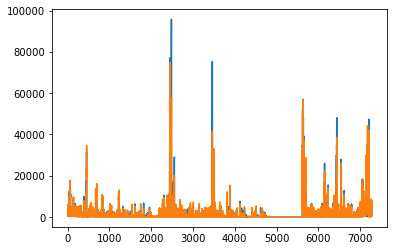

In [8]:
df_train['target_weight'] = df_train[LABEL] / df_train.groupby(['year', 'month'])[LABEL].transform('sum')
df_train['oof'] = np.expm1(oof)
score1 = np.sum((1 - np.abs(df_train[LABEL]-df_train['oof']) / (df_train[LABEL])
                 ) *
                df_train['target_weight']) / 35
print(score1)
print(np.mean(np.abs(df_train[LABEL]-np.expm1(oof))/(df_train[LABEL]+1)))
plot(df_train[LABEL])
plot(np.expm1(oof))
show()

In [9]:
feats_importance = pd.DataFrame()
feats_importance['name'] = feats
feats_importance['importance'] = importance
print(feats_importance.sort_values('importance', ascending=False)[:30])

                    name  importance
0             product_id      3083.8
46    end_stock_shift_-3      1977.6
45  start_stock_shift_-3      1272.2
43    end_stock_shift_-2      1229.4
40    end_stock_shift_-1      1222.6
42  start_stock_shift_-2       962.0
39  start_stock_shift_-1       894.4
6              end_stock       875.8
5            start_stock       748.6
69       end_stock_std_6       586.4
63           order_std_6       547.4
10     end_stock_shift_1       504.2
57       end_stock_std_3       491.0
38        order_shift_-1       486.0
60           label_std_6       474.2
32         order_shift_7       456.6
28         order_shift_6       446.6
68      end_stock_mean_6       445.8
4                  order       444.4
8          order_shift_1       434.0
56      end_stock_mean_3       422.8
36  start_stock_shift_-0       415.6
51           order_std_3       405.4
44        order_shift_-3       398.6
24         order_shift_5       395.4
16         order_shift_3       388.0
4

In [10]:
df_test[LABEL] = np.expm1(pred_lgb) #取指数还原

df_test = df_test.sort_values(by=['month', 'product_id'])
sub = pd.read_csv('data/提交示例.csv')
sub[LABEL] = df_test[LABEL].values
sub[LABEL] = sub[LABEL].map(lambda x: x if x >= 0 else 0)
 
sub.to_csv('./data/submit.csv', index=False)

NameError: name 'sun' is not defined